In [1]:
# import os

# # 设置环境变量
# os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# # 打印环境变量以确认设置成功
# print(os.environ.get('HF_ENDPOINT'))

import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

正在加载 protein_pair_short 数据集...


README.md: 0.00B [00:00, ?B/s]

protein_pair_remote/train-00000-of-00001(…):   0%|          | 0.00/88.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/359404 [00:00<?, ? examples/s]

划分数据集：train 80% / validation 10% / test 10% ...
划分完成：
  训练集: 287523 条
  验证集: 35940 条
  测试集: 35941 条


Map (num_proc=4):   0%|          | 0/287523 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/35940 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/35941 [00:00<?, ? examples/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2194/4095330684.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2}.



开始微调 ESM2...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.689800,0.689698,0.512104
2,0.689000,0.689212,0.512104
3,0.688900,0.689384,0.512104
4,0.688900,0.689189,0.512104
5,0.688800,0.689155,0.512104



=== 在独立测试集上评估 ===


最终测试集准确率: 51.3759%

Classification Report:
                    precision    recall  f1-score   support

Non-Homologous (0)     0.7613    0.0358    0.0683     17916
    Homologous (1)     0.5078    0.9888    0.6710     18025

          accuracy                         0.5138     35941
         macro avg     0.6346    0.5123    0.3697     35941
      weighted avg     0.6342    0.5138    0.3706     35941


Confusion Matrix:
[[  641 17275]
 [  201 17824]]


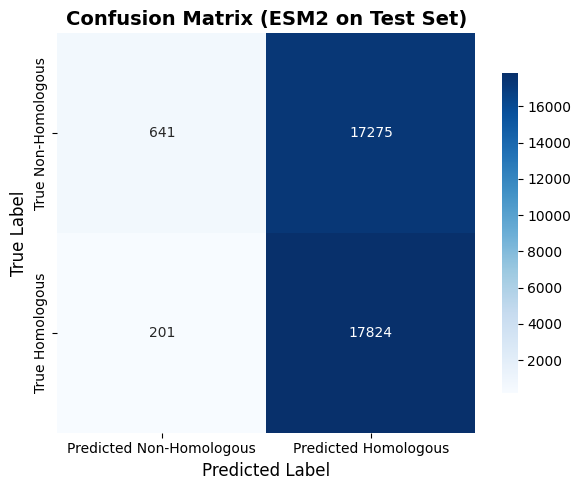


详细指标：
  True Negatives (TN):  641
  False Positives (FP): 17275
  False Negatives (FN): 201
  True Positives (TP):  17824


In [3]:
import numpy as np
import evaluate
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    set_seed
)
from datasets import load_dataset

# ==================== 配置 ====================
set_seed(42)

MODEL_CHECKPOINT = "facebook/esm2_t6_8M_UR50D"  # 小型 ESM2，适合快速实验
MAX_LENGTH = 256                               # protein_pair_short 完全覆盖
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 2e-5
OUTPUT_DIR = "./esm2_finetuned_protein_short"

# ==================== 加载并划分数据集 ====================
print("正在加载 protein_pair_short 数据集...")
full_dataset = load_dataset("dnagpt/biopaws", "protein_pair_remote")["train"]

print("划分数据集：train 80% / validation 10% / test 10% ...")
# 先分出 80% train + 20% temp
train_temp = full_dataset.train_test_split(test_size=0.2, seed=42)
# temp 再分成 validation 和 test（各10%）
val_test = train_temp["test"].train_test_split(test_size=0.5, seed=42)

datasets = {
    "train": train_temp["train"],
    "validation": val_test["train"],
    "test": val_test["test"]
}

print(f"划分完成：")
print(f"  训练集: {len(datasets['train'])} 条")
print(f"  验证集: {len(datasets['validation'])} 条")
print(f"  测试集: {len(datasets['test'])} 条")

# ==================== 分词器 ====================
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(example):
    return tokenizer(
        example["sentence1"],
        example["sentence2"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length"
    )

# 分词
tokenized_datasets = {
    split: datasets[split].map(tokenize_function, batched=True, num_proc=4)
    for split in datasets
}

# ==================== 模型 ====================
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)

# ==================== 评估指标 ====================
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=labels)

# ==================== 训练参数 ====================
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_strategy="epoch",
    report_to="none",
    seed=42,
)

# ==================== Trainer ====================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ==================== 训练 ====================
print("\n开始微调 ESM2...")
trainer.train()

# ==================== 独立测试集评估 + 详细报告 + 混淆矩阵 ====================
print("\n=== 在独立测试集上评估 ===")
test_predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(test_predictions.predictions, axis=1)
labels = test_predictions.label_ids

# 准确率
test_acc = accuracy_score(labels, preds)
print(f"最终测试集准确率: {test_acc:.4%}")

# Classification Report
print("\nClassification Report:")
print(classification_report(
    labels,
    preds,
    target_names=["Non-Homologous (0)", "Homologous (1)"],
    digits=4
))

# 混淆矩阵数值
cm = confusion_matrix(labels, preds)
print("\nConfusion Matrix:")
print(cm)

# 混淆矩阵热图
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Non-Homologous", "Predicted Homologous"],
    yticklabels=["True Non-Homologous", "True Homologous"],
    cbar_kws={"shrink": 0.8}
)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.title("Confusion Matrix (ESM2 on Test Set)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# 保存图片（可选，放论文用）
# plt.savefig("confusion_matrix_esm2_test.pdf", dpi=300, bbox_inches='tight')

# 详细 TN/FP/FN/TP
tn, fp, fn, tp = cm.ravel()
print(f"\n详细指标：")
print(f"  True Negatives (TN):  {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP):  {tp}")